In [19]:
# linear modelling functions
#HENRY AND JUN
#MERGED KAMMEN + COOLCLIMAE
#!pip install ipynb
import ipynb.fs.full.general_model_pipeline_vl as gmp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")


#### Splitting the dataset 

These models will use 80% training data and 20% of testing data.

In [20]:
rs = 100
np.random.seed(100)
train_size = 0.8

In [21]:
df1 = pd.read_csv('../../data/new-cleaned-household-data.csv')
df1['airflights'] = df1['input_footprint_transportation_airshort']+df1['input_footprint_transportation_airmedium']+df1['input_footprint_transportation_airlong']
df = df1[['input_income', 'input_footprint_transportation_num_vehicles','input_footprint_transportation_miles1', 'airflights', 'input_footprint_housing_electricity_dollars', 'input_footprint_housing_squarefeet', 'input_footprint_shopping_goods_clothing', 'result_grand_total']]

df.reset_index(drop = False, inplace = True)

train_data = df.sample(frac=train_size)
test_data = df[df['index'].apply(lambda x: x not in train_data['index'].values)]

train_data.drop(columns='index', inplace=True)
test_data.drop(columns='index', inplace=True)
train_data.shape, test_data.shape

mylist = train_data.columns
mylist[1:7]
train_data.head()

input_income  input_footprint_transportation_num_vehicles  \
588            5.0                                          1.0   
983            9.0                                          2.0   
638            6.0                                          2.0   
266            3.0                                          1.0   
1010          10.0                                          2.0   

      input_footprint_transportation_miles1  airflights  \
588                                 15600.0         2.0   
983                                 12700.0         6.0   
638                                  9400.0         7.0   
266                                  5800.0         4.0   
1010                                 8200.0         6.0   

      input_footprint_housing_electricity_dollars  \
588                                         480.0   
983                                         480.0   
638                                         670.0   
266                                         370.0   
1010                                        540.0   

      input_footprint_housing_squarefeet  \
588                               1590.5   
983                               1993.0   
638                               1689.0   
266                               1419.0   
1010                              2217.0   

      input_footprint_shopping_goods_clothing  result_grand_total  
588                                136.451019           23.324704  
983                                251.748512           37.518058  
638                                198.743174           29.656163  
266                                 81.291788           17.516040  
1010                               307.046647           37.328012

## Forecasting and Prediction Modeling 

### Model 1: Simple Linear Regression

We will begin by looking at a simple linear regression model.

Splitting data...
Fitting Model...
[Train MSE: 3.8852]
[Train R^2: 0.9666392179285809]
[Test MSE: 4.9234]
[Test R^2: 0.9570262757544852]
----FINISHED----


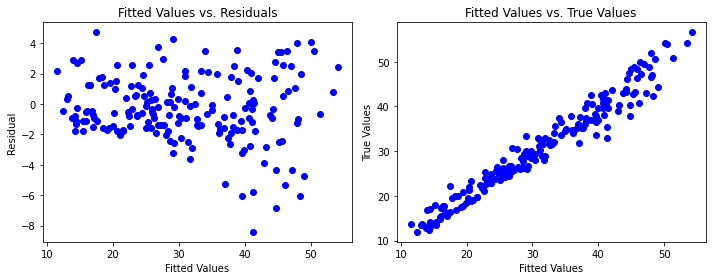

In [22]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total')
lm = LinearRegression()
lm = gmp.run_model(X_train, X_val, y_train, y_val, lm, diagnostics = True)

This model gave a Test MSE of 4.9234 and R^2 value of 0.95703, so this is a very good model.

### Model 2: Ridge Regression

Next, we look at Ridge regression. To begin, we find an optimal value of alpha, a hyperparameter, in order to decrease model variance. 

In [5]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total', standardize_cols = mylist[1:7].tolist())
                                                   #['input_footprint_transportation_num_vehicles', 'input_footprint_transportation_miles1', 'airflights', 'input_footprint_housing_electricity_dollars', 'input_footprint_housing_squarefeet', 'input_footprint_shopping_goods_clothing'])

alphas = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gmp.linreg_kfold_cv(RidgeCV, X_train, X_val, y_train, y_val, alphas)

Standardizing data...
Splitting data...
optimal alpha: 0.0
Test MSE with cross-validated RidgeCV: 4.92344121392362
[R^2: 0.957026275754538]


0.0

This gave an optimal alpha value of 0. We will zoom in around that value to see if there is an even optimal value of alpha and then see the new test MSE and R^2 value. However as the alpha value is so small, we expect that the coefficients will be almost the same as the results from linear regression. 

In [6]:
new_alphas = np.arange(0,0.0001,0.00001)
gmp.linreg_kfold_cv(RidgeCV, X_train, X_val, y_train, y_val, new_alphas)
new_alphas

optimal alpha: 6.000000000000001e-05
Test MSE with cross-validated RidgeCV: 4.926218463353111
[R^2: 0.9570020348332071]


array([0.e+00, 1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05,
       8.e-05, 9.e-05])

Fitting Model...
[Train MSE: 3.8853]
[Train R^2: 0.9666381731710392]
[Test MSE: 4.9262]
[Test R^2: 0.9570020348332071]
----FINISHED----


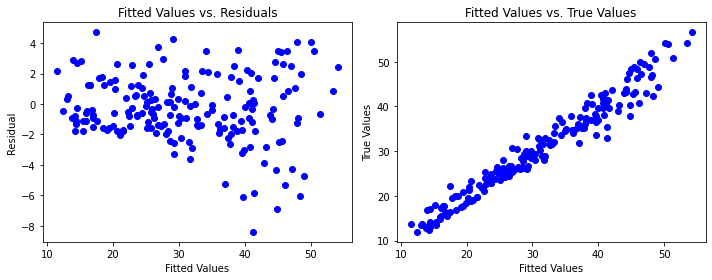

In [7]:
ridge_model = Ridge(alpha=6e-05)
ridge_model = gmp.run_model(X_train, X_val, y_train, y_val, ridge_model, diagnostics=True)

The test MSE and R^2 values stayed around the same at MSE: 4.6262 and R^2: 0.957 (compared to the test MSE of 4.9234 and R^2 value of 0.95703 in the linear model). This shows that undergoing a ridge regression model did not show that much of an improvement.

### Model 3: Lasso Regression

Next, we move on to Lasso Regression. As Ridge regression did not do much better than linear, we do not expect Lasso do perform much better as well. 

In [8]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total', standardize_cols = mylist[1:7].tolist())
alphas = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gmp.linreg_kfold_cv(LassoCV, X_train, X_val, y_train, y_val, alphas)

Standardizing data...
Splitting data...
optimal alpha: 0.0
Test MSE with cross-validated LassoCV: 4.923441213923627
[R^2: 0.9570262757545379]


0.0

Again, the optimal alpha was 0. So as we zoom in around 0 to find an even optimal value, we will keep in mind that Lasso will perform the same as linear and ridge regression. 

In [9]:
new_alphas_lasso = np.arange(0,0.001,0.00001)
gmp.linreg_kfold_cv(LassoCV, X_train, X_val, y_train, y_val, new_alphas_lasso)

optimal alpha: 1e-05
Test MSE with cross-validated LassoCV: 4.924770408176923
[R^2: 0.9570146740262289]


1e-05

Standardizing data...
Splitting data...
Fitting Model...
[Train MSE: 3.8852]
[Train R^2: 0.9666390306371127]
[Test MSE: 4.9248]
[Test R^2: 0.9570146740262289]
----FINISHED----


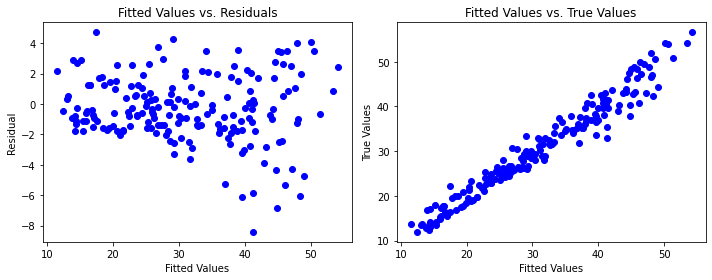

In [10]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total', standardize_cols =  mylist[1:7].tolist())

lasso_model = Lasso(alpha=1.e-05)
lasso_model = gmp.run_model(X_train, X_val, y_train, y_val, lasso_model, diagnostics=True)

Using Lasso regression, the test MSE was 4.9248 and R^2 value of 0.957 so this model performed the same as the other two. 

## Model 4: Decision Tree

Finally, we will move on to decision trees. As the linear model performed so well, we expect that decision tree model will not work as well as it uses a non-linear mapping. We begin by looking for 3 hyperparameters: max_leaf_nodes, max_features, and max_depth.

In [11]:
param_dist = {'max_leaf_nodes': np.arange(2, 20),
              'max_features': np.arange(2, 7),
              'max_depth': np.arange(2,10)}

tree = DecisionTreeRegressor(random_state = 100, max_depth = 4, max_features=5, max_leaf_nodes=10)
gmp.tree_kfold_cv(tree, param_dist, X_train, y_train, n_iter=1000, random_state = 100)

0.9009523299484729
{'max_leaf_nodes': 19, 'max_features': 6, 'max_depth': 7}


Splitting data...
Fitting Model...
[Train MSE: 8.0859]
[Train R^2: 0.9305685325376274]
[Test MSE: 10.0325]
[Test R^2: 0.9124323430698816]
----FINISHED----


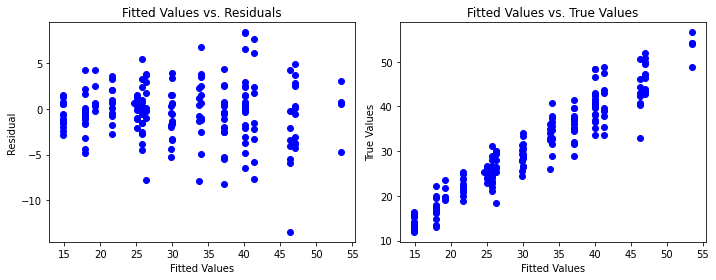

In [12]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total')

tree_model = DecisionTreeRegressor(random_state=100, max_leaf_nodes = 19,
                                   max_depth=5, max_features = 6)
tree_model = gmp.run_model(X_train, X_val, y_train, y_val, tree_model, diagnostics=True)

In [13]:
#X_train.drop(columns = 'level_0', inplace=True)
k = gmp.forward_selection(tree_model, X_train, y_train, k_features=7)
#X_train.loc[:,0:k]
print(X_train.columns)
print(k)

Index(['input_income', 'input_footprint_transportation_num_vehicles',
       'input_footprint_transportation_miles1', 'airflights',
       'input_footprint_housing_electricity_dollars',
       'input_footprint_housing_squarefeet',
       'input_footprint_shopping_goods_clothing'],
      dtype='object')
('input_income', 'input_footprint_transportation_num_vehicles', 'input_footprint_transportation_miles1', 'airflights', 'input_footprint_housing_electricity_dollars', 'input_footprint_housing_squarefeet', 'input_footprint_shopping_goods_clothing')


As expected, using a decision tree model performed the worst out of all of the model above as it had the highest test MSE of 10.0325 and lowest R^2 value of 0.9124. In addition, the fitted values had a high variance.

## Comparison on Test Set

In [14]:
from sklearn.preprocessing import normalize


data = test_data.copy().reset_index().drop(columns=['result_grand_total', 'index'])
standardize_features = normalize(data.loc[:, mylist[1:7]], axis=0)
standardize_df = pd.DataFrame(standardize_features, columns=mylist[1:7])

data.drop(mylist[1:7], axis = 1, inplace = True)
data = pd.concat([data, standardize_df], axis= 1)
data

X_test = test_data.drop(columns='result_grand_total')
y_test = test_data['result_grand_total']



In [15]:
lr_test_preds = lm.predict(X_test)
ridge_test_preds = ridge_model.predict(data)
lasso_test_preds = lasso_model.predict(data)
tree_test_preds = tree_model.predict(X_test)


{'Linear Regression' : mean_squared_error(lr_test_preds, y_test),
 'Ridge Regression' : mean_squared_error(ridge_test_preds, y_test),
 'Lasso Regression' : mean_squared_error(lasso_test_preds, y_test),
 'Decision Tree' : mean_squared_error(tree_test_preds, y_test)}

{'Linear Regression': 4.925913086620728,
 'Ridge Regression': 1717.6098551087346,
 'Lasso Regression': 1725.051929297688,
 'Decision Tree': 11.42033901953504}

## Interpretation and Conclusions

In [45]:
def lin_model_features(model, X_train, X_val, y_train, y_val, num_feat):
    k = gmp.forward_selection(model, X_train, y_train, k_features=num_feat)
    X_train1 = X_train.loc[:,list(k)]
    X_val1 = X_val.loc[:,list(k)]
    return gmp.run_model(X_train1, X_val1, y_train, y_val, model, diagnostics = False)

In [32]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total')

for i in range(1,X_train.shape[1]+1):
    print(lin_model_features(LinearRegression(), X_train, X_val, y_train, y_val, i))


Splitting data...
Fitting Model...
[Train MSE: 13.4334]
[Train R^2: 0.8846513925656855]
[Test MSE: 17.7178]
[Test R^2: 0.8453524911452459]
----FINISHED----
LinearRegression()
Fitting Model...
[Train MSE: 10.2835]
[Train R^2: 0.9116991249636762]
[Test MSE: 12.8573]
[Test R^2: 0.887776708749524]
----FINISHED----
LinearRegression()
Fitting Model...
[Train MSE: 4.9102]
[Train R^2: 0.9578380360019337]
[Test MSE: 5.8188]
[Test R^2: 0.9492108894173422]
----FINISHED----
LinearRegression()
Fitting Model...
[Train MSE: 4.5428]
[Train R^2: 0.9609927068556756]
[Test MSE: 5.5535]
[Test R^2: 0.9515272896328884]
----FINISHED----
LinearRegression()
Fitting Model...
[Train MSE: 4.17]
[Train R^2: 0.9641938848231896]
[Test MSE: 5.2493]
[Test R^2: 0.9541817112337466]
----FINISHED----
LinearRegression()
Fitting Model...
[Train MSE: 3.9018]
[Train R^2: 0.9664964393471359]
[Test MSE: 4.9656]
[Test R^2: 0.956658141883105]
----FINISHED----
LinearRegression()
Fitting Model...
[Train MSE: 3.8852]
[Train R^2: 0.9

In [77]:
best_lm = lin_model_features(LinearRegression(), X_train, X_val, y_train, y_val, 6)

Fitting Model...
[Train MSE: 3.9018]
[Train R^2: 0.9664964393471359]
[Test MSE: 4.9656]
[Test R^2: 0.956658141883105]
----FINISHED----



Since the goal of this prediction problem was to make a model where we used less and less features compared to the total API data and every feature played an important part in predicting the total carbon output, it seemed that a simple linear model sufficed for this question. As the Lasso, Ridge, and linear regression models all had a very similar MSE and R^2 value, it seemed that the linear model performed just as good as Lasso and ridge. In addition, when searching for the optimum alpha values for both Ridge and Lasso through cross validation, both were very small, (in the 10^-6 realm) which made the coefficients of both models close to thtat of the linear regression model. Looking at the decision tree model, the fitted values had a higher variance compared to the linear models and it did not perform as well as the other three models as it uses a non-linear relationship. Looking at the test data and the MSE values, we see that the linear regression model had the lowest MSE, which made it the best performing model. 

In addition, we performed a forward feature selection to select the best set of features. It appeared that there were features that were more important than others. In order to see the difference in the test MSE and R^2 value, we performed a linear regression model on the different number of features. It appeared that once we started using 3 selected features, the R^2 values hit around 94% and stayed in the realm. In addition, the 2nd to last regression model, which uses 6 of the best features, had a similar R^2 and MSE value compared to using all 7 features. 

Through this features selection, we can create a simplified calculator that only uses these selected, important features. For example, a user could find a very rough estimate of their carbon footprint using the top features selected by the forward feature selection, and based on the results, could see if their rough estimate is very high and then be pushed to take the full carbon footprint to see where their top emitters are coming from.

However, we must keep in mind that forward selection suffers from state dependencies as it includes best features from prior levels and does not evaluate all models so we can’t be sure it found the best features.



In [80]:
# try inserting your own estimated features!

user_features = {'input_income' : 3,
                 'input_footprint_transportation_num_vehicles' : 1,
                 'input_footprint_transportation_miles1' : 8600, 
                 'airflights' : 2,
                 'input_footprint_housing_electricity_dollars' : 360,
                 'input_footprint_shopping_goods_clothing' : 100}

In [81]:
predicted_co2_emissions_per_year = best_lm.predict(np.reshape(list(user_features.values()), (1,6)))[0]
print('Your features produce', np.round(predicted_co2_emissions_per_year, 2), 'ton of CO2 emissions per year.')

Your features produce 1719.06 ton of CO2 emissions per year.
